In [23]:
import pandas as pd
import numpy as np

def look_n_load(path):
    df = pd.read_csv(path)
    print('\nShape:', df.shape)
    print('\nColumns:', list(df.columns))
    # print('\nData Type:',df.info())
    # print('\n',df.describe())
    print('\nMissing proportions:\n', df.isna().sum()/len(df))
    return df

In [6]:
triage = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/triage.csv')

In [7]:
vitals = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/vitalsign.csv')

In [8]:
edstays = look_n_load('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/edstays.csv')


Shape: (447712, 9)

Columns: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition']

Missing proportions:
 subject_id           0.000000
hadm_id              0.522213
stay_id              0.000000
intime               0.000000
outtime              0.000000
gender               0.000000
race                 0.000000
arrival_transport    0.000000
disposition          0.000000
dtype: float64


# Initial Data Analysis (with sweetviz)


In [9]:
# import sweetviz as sv

# my_report = sv.analyze(edstays)
# my_report.show_html()

In [10]:
# import sweetviz as sv
# # create a list object to store all dataframes
# lst = [diagnosis, edstays, medrecon, pyxis, triage, vitalsign]
# for i in lst:
#     # use sweetviz to analyze each dataframe
#     my_report = sv.analyze(i)
#     # show the html report
#     my_report.show_html()  
    
    

# Initial Data Visualization

d:\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


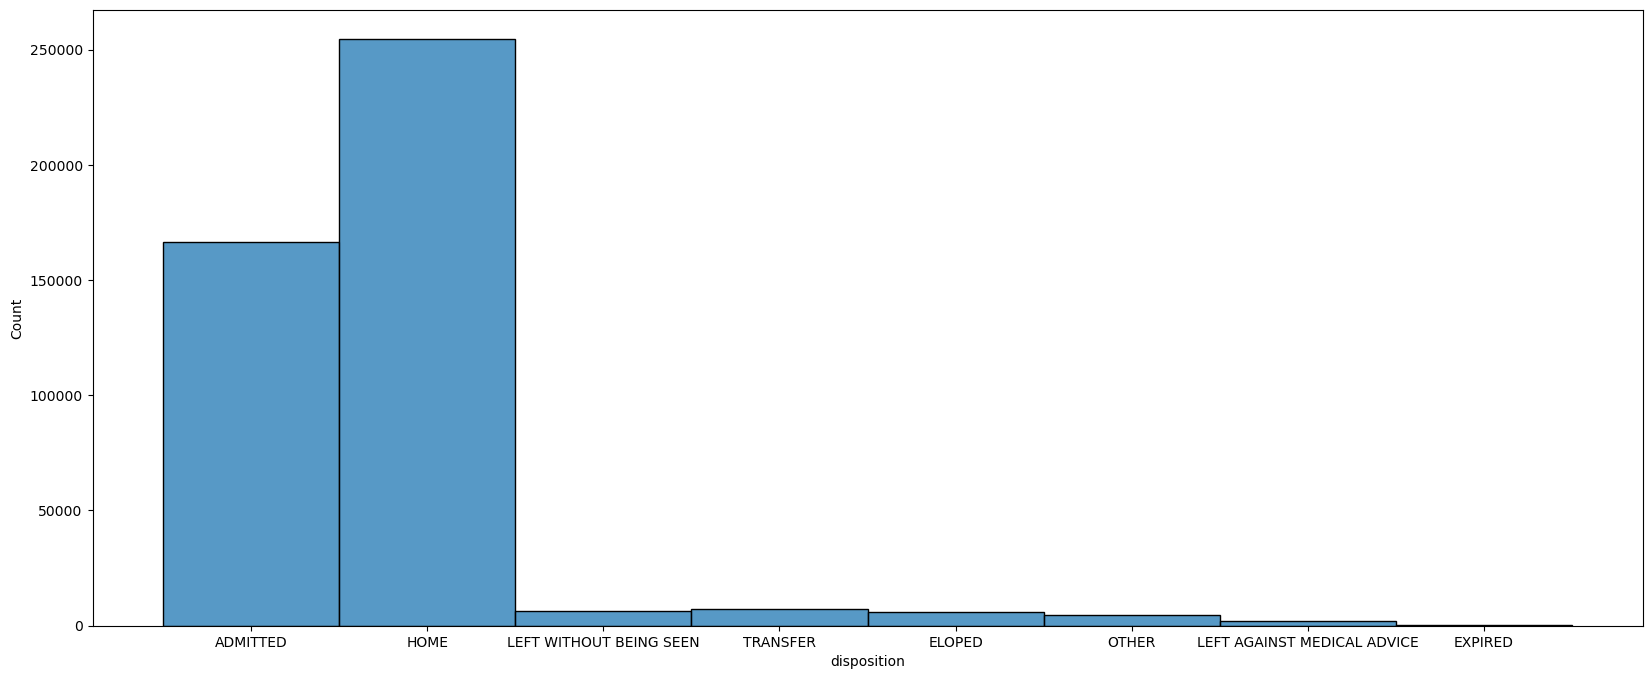

In [11]:
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
# # build a bar chart for disposition column in dataframe edstays
# fig = px.histogram(edstays, x='disposition', template='plotly_white', text_auto=True)
# fig.update_layout(title='Histogram of Disposition')
# fig.show()

# plot the histogram of disposition using seaborn
plt.figure(figsize=(20,8))
ax = sns.histplot(data=edstays, x="disposition")


In [12]:
edstays['disposition'].value_counts()

HOME                           254545
ADMITTED                       166303
TRANSFER                         7436
LEFT WITHOUT BEING SEEN          6516
ELOPED                           6011
OTHER                            4520
LEFT AGAINST MEDICAL ADVICE      1986
EXPIRED                           395
Name: disposition, dtype: int64

# Data Preprocessing and merging

In [13]:
# create new column for disposition
# in column disposition, if value is 'EXPIRED' then assign 1, otherwise assign 0
edstays['disposition_binary'] = edstays['disposition'].apply(lambda x: 1 if x == 'EXPIRED' else 0)

In [14]:
edstays['disposition_binary'].value_counts()


0    447317
1       395
Name: disposition_binary, dtype: int64

<AxesSubplot:xlabel='disposition_binary', ylabel='count'>

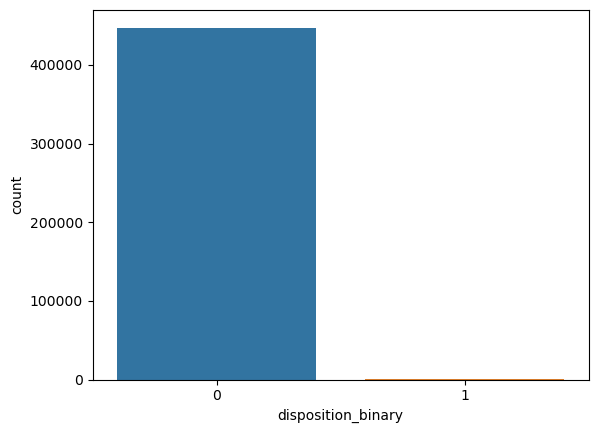

In [15]:
# histogram of disposition_binary
# fig = px.histogram(edstays, x='disposition_binary', template='plotly_white', text_auto=True)
# fig.update_layout(title='Histogram of Disposition Binary')
# fig.show()

sns.countplot(x="disposition_binary", data=edstays)

- 0 means patient is not expired, have 447317 records
- 1 means patient is expired, have  395 records
- data is highly imbalanced

In [16]:
def find_admission(x):
    if x in ['ADMITTED', 'TRANSFER']:
        return 1
    else:
        return 0
    
edstays['admitted'] = edstays['disposition'].apply(find_admission)

In [17]:
# Author: Samuel Holt 
# url: https://github.com/ApacheStark/uwa-capstone-project
# Thanks Samuel for providing code for data preprocessing
if type(edstays['intime'][0]) == type('str'): 
    edstays['intime'] = pd.to_datetime(edstays['intime'])
    edstays['outtime'] = pd.to_datetime(edstays['outtime'])

    edstays['difftime'] = edstays['outtime'] - edstays['intime']
    edstays['nights'] = [x.days for x in edstays.difftime]
    edstays['hours'] = [round(x.total_seconds() / 60 / 60, 1) for x in edstays.difftime]

    # need to ensure exact time of dishcarge has been maintained and only the date ambiguated 
    edstays['discharge_hour'] = [x.hour for x in edstays.outtime]
    edstays['admission_hour'] = [x.hour for x in edstays.intime]

    edstays['admission_date'] = [x.date() for x in edstays.intime]
    edstays['admission_day'] = [x.day for x in edstays.intime]

patients_seen = pd.DataFrame(edstays['admission_date'].value_counts()).reset_index()
patients_seen = patients_seen.rename(columns={'index':'admission_date', 'admission_date':'patients_seen'})

admitted_patients = edstays[edstays['admitted']==1]
hospital_capacity = pd.DataFrame(admitted_patients['admission_date'].value_counts()).reset_index()
hospital_capacity = hospital_capacity.rename(columns={'index':'admission_date', 'admission_date':'capacity'})

edstays.head(10)

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,disposition_binary,admitted,difftime,nights,hours,discharge_hour,admission_hour,admission_date,admission_day
0,10000032,22595853.0,33258284,2180-06-05 19:17:00,2180-06-05 23:30:00,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 04:13:00,0,4.2,23,19,2180-06-05,5
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 05:37:00,0,5.6,21,15,2180-06-26,26
2,10000032,25742920.0,35968195,2180-05-08 20:58:00,2180-06-08 01:44:00,F,WHITE,AMBULANCE,ADMITTED,0,1,30 days 04:46:00,30,724.8,1,20,2180-05-08,8
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,0,0,0 days 13:30:00,0,13.5,5,16,2180-07-22,22
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 08:06:00,0,8.1,14,5,2180-07-23,23
5,10000084,23052089.0,35203156,2160-11-20 20:36:00,2160-11-21 03:20:00,M,WHITE,WALK IN,ADMITTED,0,1,0 days 06:44:00,0,6.7,3,20,2160-11-20,20
6,10000084,29888819.0,36954971,2160-12-27 18:32:00,2160-12-28 16:07:00,M,WHITE,AMBULANCE,HOME,0,0,0 days 21:35:00,0,21.6,16,18,2160-12-27,27
7,10000108,27250926.0,36533795,2163-09-27 16:18:00,2163-09-28 09:04:00,M,WHITE,WALK IN,HOME,0,0,0 days 16:46:00,0,16.8,9,16,2163-09-27,27
8,10000108,NaN,32522732,2163-09-16 16:34:00,2163-09-16 18:13:00,M,WHITE,WALK IN,HOME,0,0,0 days 01:39:00,0,1.6,18,16,2163-09-16,16
9,10000108,NaN,39513268,2163-09-24 16:14:00,2163-09-24 21:02:00,M,WHITE,WALK IN,HOME,0,0,0 days 04:48:00,0,4.8,21,16,2163-09-24,24


In [18]:
edstays['admission_day_of_week'] = [x.weekday() for x in edstays.intime]

In [19]:
edstays.groupby(['disposition', 'arrival_transport']).size()

disposition                  arrival_transport
ADMITTED                     AMBULANCE             86800
                             HELICOPTER              804
                             OTHER                   428
                             UNKNOWN                6702
                             WALK IN               71569
ELOPED                       AMBULANCE              1760
                             HELICOPTER                1
                             OTHER                    13
                             UNKNOWN                1198
                             WALK IN                3039
EXPIRED                      AMBULANCE               312
                             HELICOPTER               18
                             UNKNOWN                  33
                             WALK IN                  32
HOME                         AMBULANCE             68335
                             HELICOPTER               48
                             OTHER       

In [20]:
edstays2  = edstays_triage = pd.merge(edstays, triage, on=['subject_id','stay_id'], how='left')
edstays2.head()

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,disposition_binary,...,admission_day_of_week,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,22595853.0,33258284,2180-06-05 19:17:00,2180-06-05 23:30:00,F,WHITE,AMBULANCE,ADMITTED,0,...,0,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,0,...,0,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
2,10000032,25742920.0,35968195,2180-05-08 20:58:00,2180-06-08 01:44:00,F,WHITE,AMBULANCE,ADMITTED,0,...,0,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,0,...,5,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,0,...,6,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


In [24]:
vitals_disp = pd.merge(edstays2[['subject_id','stay_id','disposition']], vitals, on=['subject_id','stay_id'], how='left')
   
vitals_disp['charttime'] = pd.to_datetime(vitals_disp['charttime'])
vitals_disp = vitals_disp.sort_values(['stay_id','subject_id','charttime'])
vitals_median = vitals_disp[['temperature','heartrate', 'resprate', 'o2sat','sbp','dbp']].agg(np.median).reset_index()  
vitals_median.columns = ['var','value']

for var in vitals_median['var']:
  print(var)
  vitals_disp[var] = vitals_disp[var].fillna(vitals_median[vitals_median['var']==var]['value'].values[0])

vitals_last = vitals_disp.drop(columns=['disposition', 'charttime']).groupby(['subject_id', 'stay_id']).last().reset_index()

temperature
heartrate
resprate
o2sat
sbp
dbp


In [25]:
vitals_last_rename = {
    'temperature':'last_temperature', 
    'heartrate':'last_heartrate', 
    'resprate':'last_resprate',
    'o2sat':'last_o2sat',
    'sbp':'last_sbp', 
    'dbp':'last_dbp', 
    'rhythm':'last_rhythm', 
    'pain':'last_pain'
}

vitals_last = vitals_last.rename(columns=vitals_last_rename)

In [31]:
edstays3  = edstays_triage = pd.merge(edstays2, vitals_last, how='left', left_index=True, right_index=True, suffixes=['_triage', '_vitals'])
edstays3.shape

(447712, 38)

In [32]:
edstays3.columns

Index(['subject_id_triage', 'hadm_id', 'stay_id_triage', 'intime', 'outtime',
       'gender', 'race', 'arrival_transport', 'disposition',
       'disposition_binary', 'admitted', 'difftime', 'nights', 'hours',
       'discharge_hour', 'admission_hour', 'admission_date', 'admission_day',
       'admission_day_of_week', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint',
       'subject_id_vitals', 'stay_id_vitals', 'last_temperature',
       'last_heartrate', 'last_resprate', 'last_o2sat', 'last_sbp', 'last_dbp',
       'last_rhythm', 'last_pain'],
      dtype='object')

In [33]:
edstays3.disposition.value_counts()

HOME                           254545
ADMITTED                       166303
TRANSFER                         7436
LEFT WITHOUT BEING SEEN          6516
ELOPED                           6011
OTHER                            4520
LEFT AGAINST MEDICAL ADVICE      1986
EXPIRED                           395
Name: disposition, dtype: int64

- Now the dataset have 39 columns and around 447712 rows

In [34]:
# output csv
edstays3.to_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/edstays3_for_TL.csv')

# Exploratory Data Analysis

## Correlation Heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

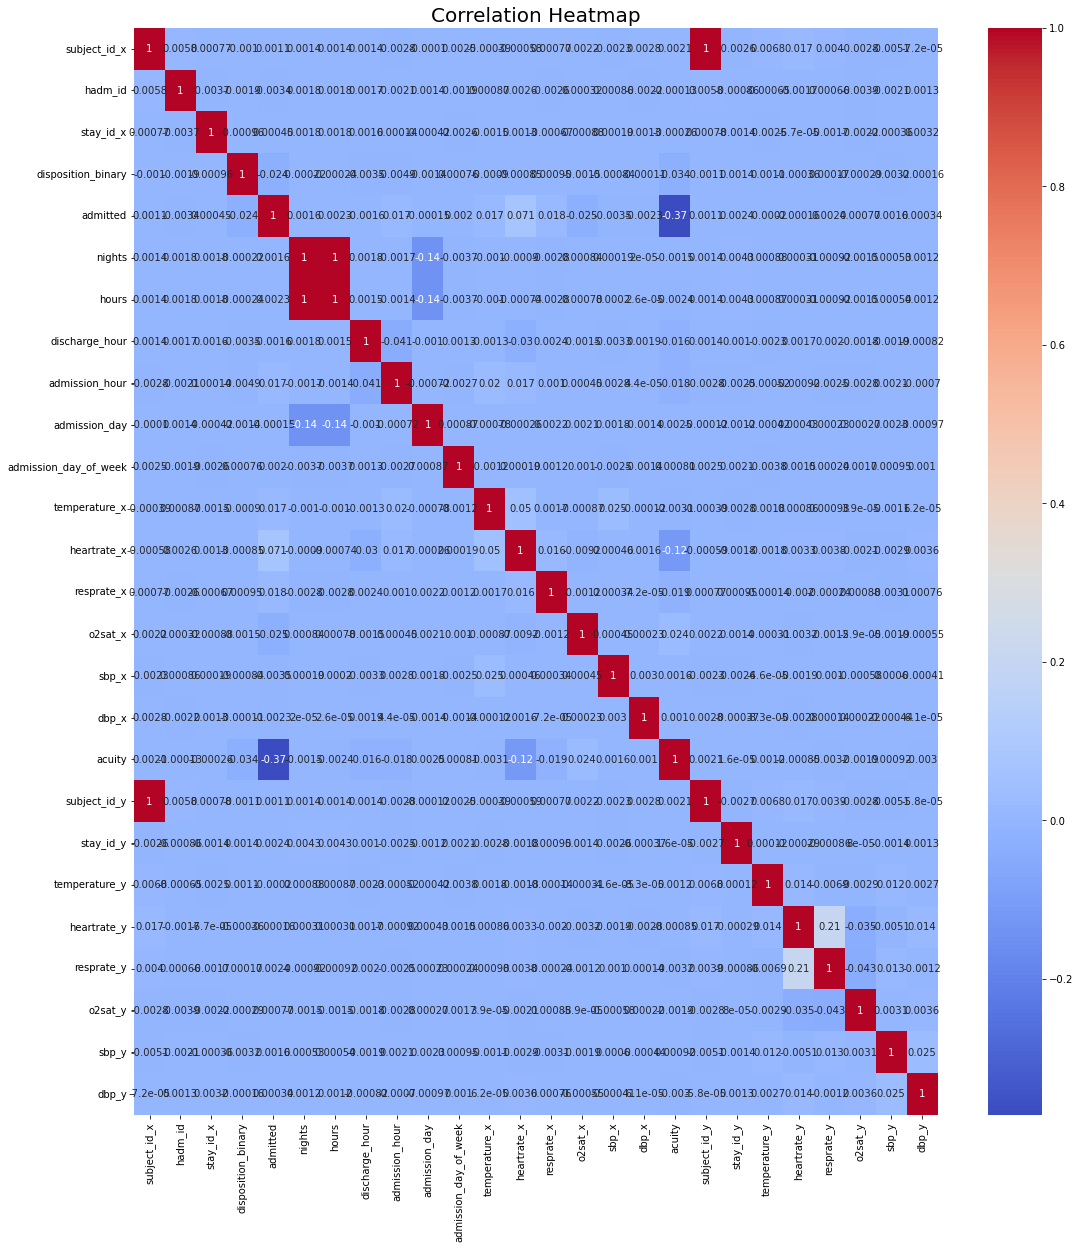

In [ ]:
# Create correlation heatmap
# set fig size
plt.figure(figsize=(18, 20))
plt = sns.heatmap(edstays3.corr(), cmap='coolwarm', annot=True)
plt.set_title('Correlation Heatmap', fontsize=20)

- The main variable to look at is the disposition_binary, which is the binary version of the disposition column.
- In general, this column have a very low correlation with other variables.

## Data visualization

- The code below use plotly to create, plotly is a library that can create interactive plots.
- However, since the size of the dataset is too large, the plotly cannot be rendered in github.
- Therefore, the code below is commented out and added the png file of the plotly plot.

In [ ]:
# changed as comment since the picture size is too big

# histogram of disposition_binary
# fig = px.histogram(edstays3, x='disposition', template='plotly_white', text_auto=True, color='gender')
# fig.update_layout(title='Histogram of Disposition')
# fig.show()

In [ ]:
# changed as comment since the picture size is too big

# fig = px.histogram(edstays3, x='disposition_binary' ,template='plotly_white', text_auto=True)
# fig.update_layout(title='Histogram of Disposition')
# fig.show()

- data imbalance issue is found
- with 945.873k records are not expired patients vs only 819 expired patients records

## Data visualization for EXPIRED patients to check hidden patterns 

In [ ]:
# we would also like to see the EXPIRED patients pattern
expired_df = edstays3[edstays3['disposition_binary'] == True]

In [ ]:
# code to produce the figure, since the figure is too big, we comment it out and inserted the picture in markdown
# fig = px.histogram(expired_df, y='disposition_binary', x='race' ,template='plotly_white', text_auto=True)
# fig.update_layout(title='Histogram of Disposition patient (Group by Race)')
# # sort the histogram by y-axis
# fig.update_xaxes(categoryorder="total ascending")
# fig.show()

<img src='figure/updated/race_by_expired.png' width="1000" height="400">

- majority of the expired race record is *WHITE*, second is *BLACK/AFRICAN AMERICAN*
- The third majority is *UNKNOWN*, There are 70 records 

In [ ]:
# fig = px.histogram(expired_df, y='disposition_binary', x='arrival_transport' ,template='plotly_white', text_auto=True)
# fig.update_layout(title='Histogram of Disposition patient (Group by Arrival Transport)')
# # sort the histogram by y-axis
# fig.update_xaxes(categoryorder="total ascending")
# fig.show()

<img src='figure/updated/arrival_transport.png' width="1000" height="400">

- Majority of the expired patients are using *ambulance* as their arrival transport

In [ ]:
# fig = px.histogram(expired_df, y='disposition_binary', x='acuity' ,template='plotly_white', text_auto=True)
# fig.update_layout(title='Histogram of Disposition patient (Group by acuity)')
# # sort the histogram by y-axis
# fig.update_xaxes(categoryorder="total ascending")
# fig.show()

<img src='figure/updated/acuity_hist.png' width="1000" height="400">

- The above figure the acuity of the patients who expired, we can see that the acuity of the patients who expired is mostly 1


## Using boxplot to see the compare the patient diagnosis detail between EXPIRED and NOT EXPIRED 

In [ ]:
# create new column 'abs_hours' for turning 'hours' to absolute value
edstays3['abs_hours'] = edstays3['hours'].apply(lambda x: abs(x))

In [ ]:
# fig = px.box(edstays3, x='disposition_binary', y='abs_hours')
# fig.update_traces(boxpoints=False, boxmean=True)
# fig.update_layout(title='Boxplot of Admission Hour by Disposition')
# # update x-axis name, 0 = not expired, 1 = expired
# fig.update_xaxes(title_text='Disposition', ticktext=['Not Expired', 'Expired'], tickvals=[0, 1])
# fig.show()

<img src='figure/abs_hours_box.png' width="1000" height="400">

- a very skewed distribution is found in the data
- the median admission total time for Not Expired patients is 5.9 , while for Expired patients is 6.1
- the mean admission total time for Not Expired patients is 170, while for Expired patients is 181
- generally, the admission total time for Expired patients is longer than Not Expired patients (skewed distribution so use median)

In [ ]:
# fig = px.box(edstays3, x='disposition_binary', y='temperature')
# fig.update_traces(boxpoints=False, boxmean=True)
# fig.update_layout(title='Comparison of Temperature by Not Expired and Expired patients')
# # update x-axis name, 0 = not expired, 1 = expired
# fig.update_xaxes(title_text='Disposition', ticktext=['Not Expired', 'Expired'], tickvals=[0, 1])
# fig.show()

<img src='figure/temperature_box.png' width="1000" height="400">

- Not Expired patients have a large range of temperature, but the median and mean is around 98
- Expired patients have a smaller range of temperature, but the median and mean is 97.9 and 97.25
- Unusal temperature range is found in the Not Expired patients (986 temperature?)
- Further data cleaning is needed to remove the outliers

In [ ]:
# fig = px.box(edstays3, x='disposition_binary', y='heartrate')
# fig.update_traces(boxpoints=False, boxmean=True)
# fig.update_layout(title='Comparison of Heart Rate by Not Expired and Expired patients')
# # update x-axis name, 0 = not expired, 1 = expired
# fig.update_xaxes(title_text='Disposition', ticktext=['Not Expired', 'Expired'], tickvals=[0, 1])
# fig.show()

<img src='figure/heartrate_box.png' width="1000" height="400">

- Again, unusal values are present in Not Expired patients (1228 heart rate?), but not in Expired patients
- Not Expired patients have 83 median heart rate, while Expired patients have 82 median heart rate
- Further cleaning is needed (e.g remove records that have heart rate > certain value)
- Further analysis of other columns *resprate*, *o2sat*, *sbp*, *dbp*, *resprate*

In [ ]:
# count column pain
edstays3['pain'].value_counts()

- For the pain column, there are a total of 875 different reported levels of pain.


In [ ]:
# fig = px.box(edstays3, x='disposition_binary', y='acuity')
# fig.update_traces(boxpoints=False, boxmean=True)
# fig.update_layout(title='Comparison of Acuity by Not Expired and Expired patients')
# # update x-axis name, 0 = not expired, 1 = expired
# fig.update_xaxes(title_text='Disposition', ticktext=['Not Expired', 'Expired'], tickvals=[0, 1])
# fig.show()

<img src='figure/acuity_disposition_bin_box.png' width="1000" height="400">

- Not Expired patients have higher acuity mean and median than Expired patients (2.6 and 3)
- while Expired patients have 1.57 mean and 1 median
- the inter quartile range of Not Expired patients is also higher than Expired patients

## Time Series Analysis
- We would like to see the trend of Expired patients and Not Expired patients from time Series

In [ ]:
# fig = px.histogram(edstays3[edstays3['disposition_binary'] == True], y='disposition_binary', x='admission_day_of_week' ,template='plotly_white', text_auto=True, marginal="box")
# fig.update_layout(title='Histogram of admission day of week (Expired Patients)')
# # sort the histogram by y-axis
# fig.update_xaxes(categoryorder="total ascending")
# # fig.show()

<img src='figure/updated/admit_day_hist_box.png' width="1000" height="400">

- No special pattern is found for which day of week have any suspicious pattern

In [ ]:
fig = px.histogram(edstays3[edstays3['disposition_binary'] == True], y='disposition_binary', x='admission_hour' ,template='plotly_white', text_auto=True, marginal="rug")
fig.update_layout(title='Histogram of admission hour (Expired Patients)')
# sort the histogram by y-axis
fig.update_xaxes(categoryorder="total ascending")
fig.show()

- From 9:00 A.M to 5:00 P.M is peek time compared to other time
- Especially 9:00 A.M to 10:00 A.M and 4:00 P.M to 5:00 P.M have more admission hour for expired patients compared to other time